In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Import Data

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=['Date'], index_col='Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<AxesSubplot:xlabel='Date'>

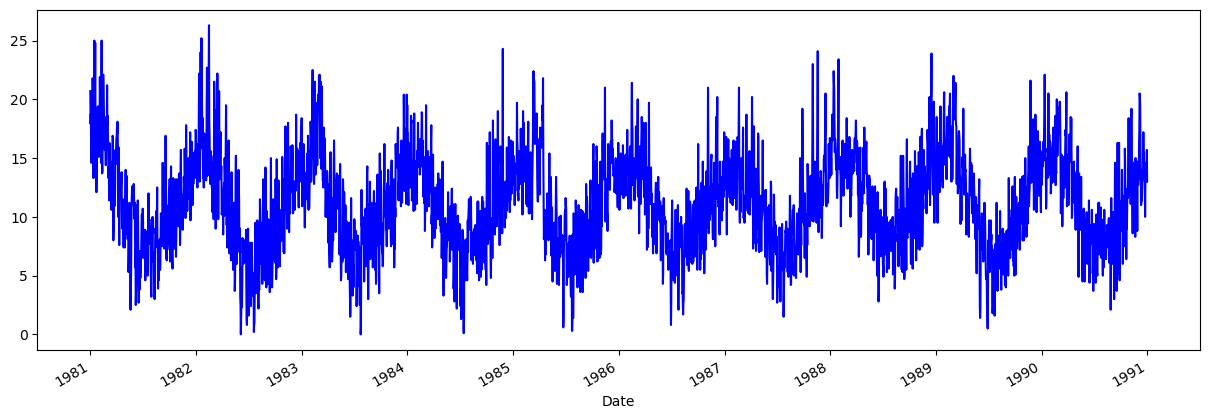

In [4]:
df.Temp.plot(figsize=(15, 5), color='b')

Note: data harian banyak noise nya karena jika memaka time yang lebih kecil contoh harian, menit, jam datanya jadi noisy sehingga jadi susah prediksinya. bisa saja tapi pakai rnn tapi lebih baik time yang lebih besar mingguan, bulanan

In [5]:
df = df.resample("W").mean()

<AxesSubplot:xlabel='Date'>

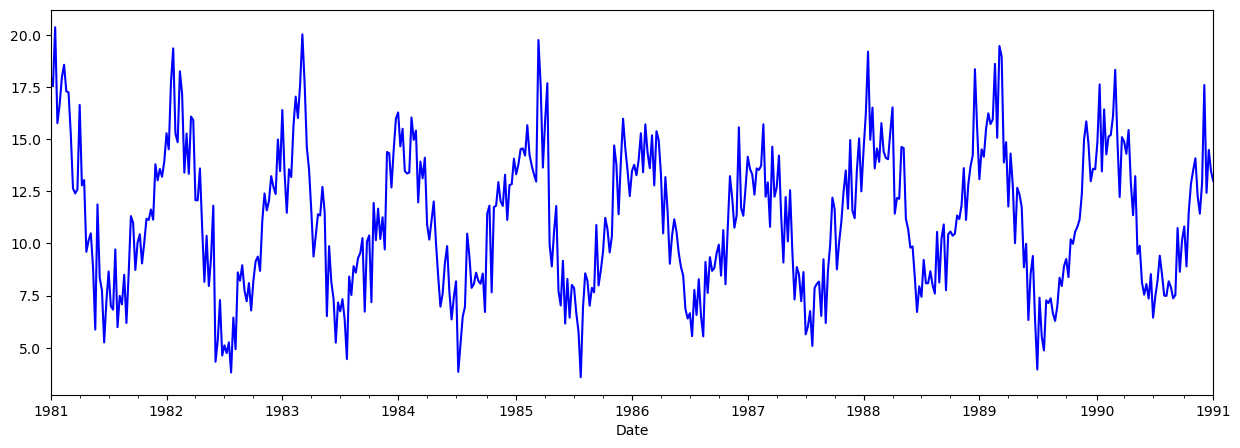

In [6]:
df.Temp.plot(figsize=(15, 5), color='b')

Jika pakai data lebih besar maka lakukan resampling

# Dataset Splitting

Dataset time series jangan di shuffle 

In [7]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

# Dataset & Data loader

Note:
* kalau pakai data multilabel pakai multilabeldataset
* kalau multi class pakai image class
* kalau tabular kita pakai tensor dataset
* kalau timeseries di jcopdl pakai timeseriesDataset

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

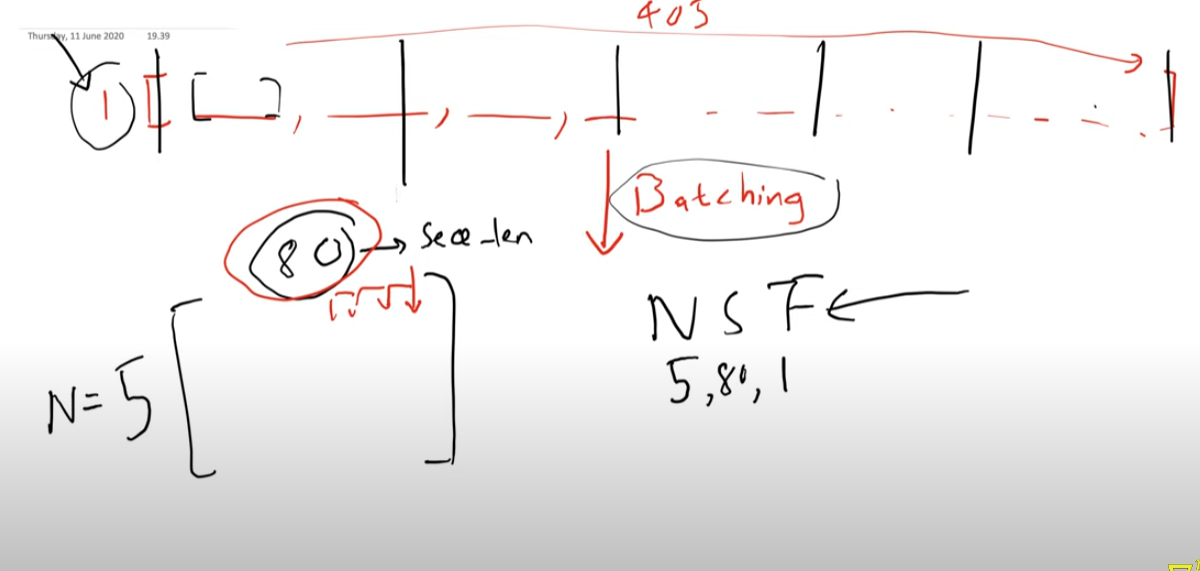

In [24]:
# seq_len = 6 # 6 minggu
# seq_len = 16 #16 minggu = 4 bulan
# seq_len = 14 # artinya Backpropagation Throught Time sampai 14 hari ke belakang
seq_len = 21
# bs = 16
bs = 16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=False)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs, shuffle=False)

(N, S, F): (19, 21, 1)
Note: last 18 data excluded

(N, S, F): (4, 21, 1)
Note: last 20 data excluded



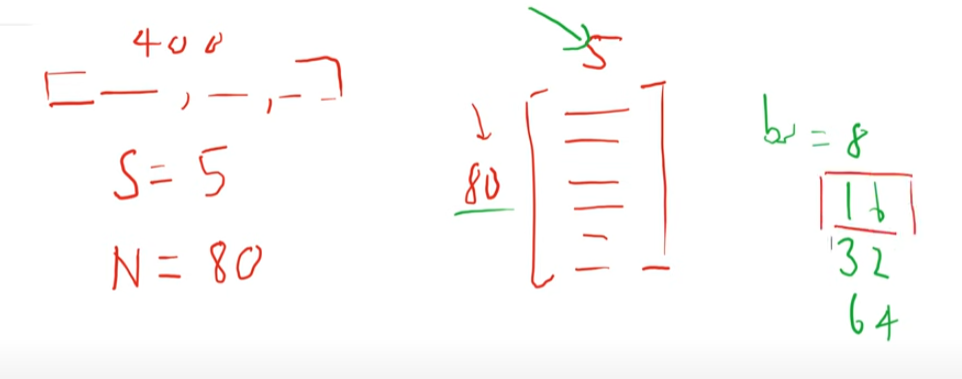

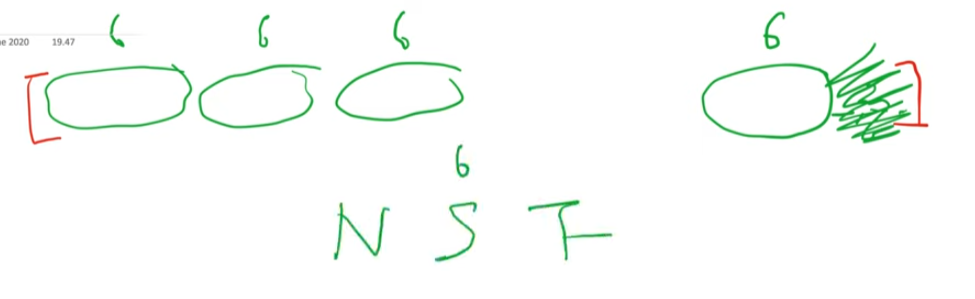

excluded maksudnya data dibuang atau diabaikan

# Arsitektur & Config

In [25]:
from jcopdl.layers import linear_block

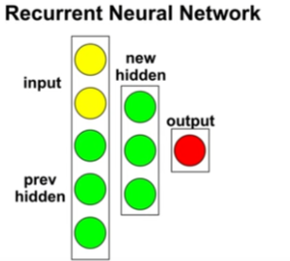

* layer pertama dan kedua itu sudah dibungkus oleh Pytorch next nya tinggal kombinasi linear ke output

In [26]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size ,output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

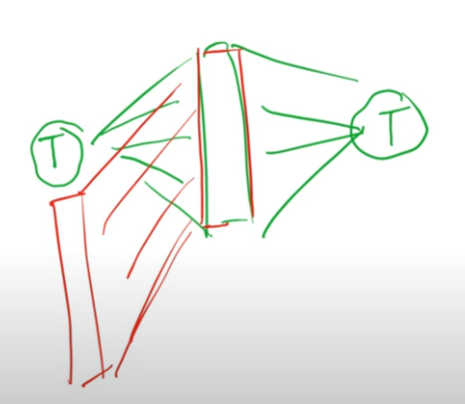

In [27]:
train_set.n_feature

1

In [28]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 3, 
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation -> MCOC

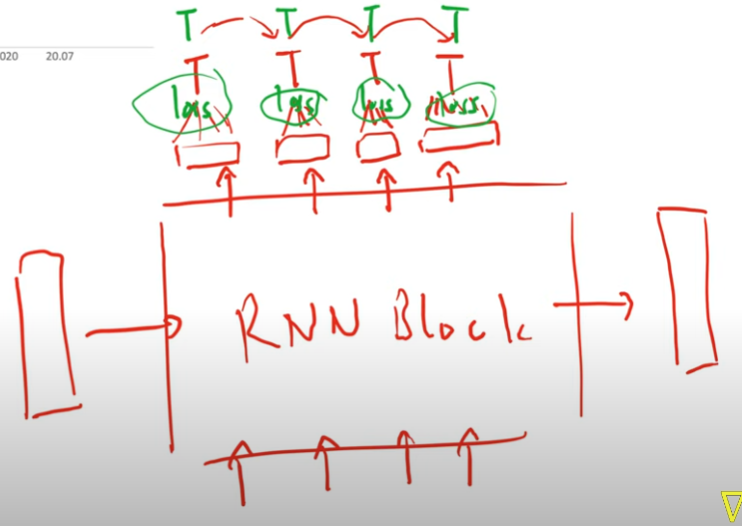

In [29]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

# Training

In [30]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 135.4485 | Test_cost  = 139.0124 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 128.1043 | Test_cost  = 132.1281 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 121.4035 | Test_cost  = 125.2289 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 114.6312 | Test_cost  = 117.7872 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 107.3191 | Test_cost  = 109.8258 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 99.5374 | Test_cost  = 101.7630 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 91.7232 | Test_cost  = 94.1302 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 84.3938 | Test_cost  = 87.3074 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 77.8974 | Test_cost  = 81.4398 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 72.3500 | Test_cost  = 76.4877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 67.6941 | Test_cost  = 72.3106 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 63.7815 | Test_cost  = 68.7320 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 60.4360 | Test_cost  = 65.5858 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 57.4967 | Test_cost  = 62.7498 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 54.8476 | Test_cost  = 60.1440 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 52.4137 | Test_cost  = 57.7179 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 50.1484 | Test_cost  = 55.4408 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 48.0237 | Test_cost  = 53.2940 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 46.0226 | Test_cost  = 51.2649 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 44.1335 | Test_cost  = 49.3430 | 


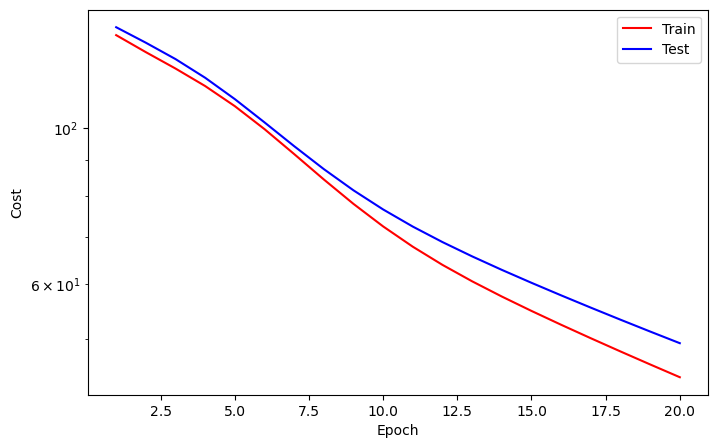

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 42.3465 | Test_cost  = 47.5192 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 40.6528 | Test_cost  = 45.7855 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 39.0448 | Test_cost  = 44.1352 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 37.5163 | Test_cost  = 42.5631 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 36.0623 | Test_cost  = 41.0646 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 34.6789 | Test_cost  = 39.6362 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 33.3625 | Test_cost  = 38.2743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 32.1099 | Test_cost  = 36.9762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 30.9185 | Test_cost  = 35.7392 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 29.7856 | Test_cost  = 34.5607 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 28.7090 | Test_cost  = 33.4386 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 27.6863 | Test_cost  = 32.3705 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 26.7155 | Test_cost  = 31.3545 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 25.7944 | Test_cost  = 30.3884 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 24.9211 | Test_cost  = 29.4703 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 24.0936 | Test_cost  = 28.5982 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 23.3100 | Test_cost  = 27.7703 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 22.5685 | Test_cost  = 26.9848 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 21.8673 | Test_cost  = 26.2399 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 21.2045 | Test_cost  = 25.5338 | 


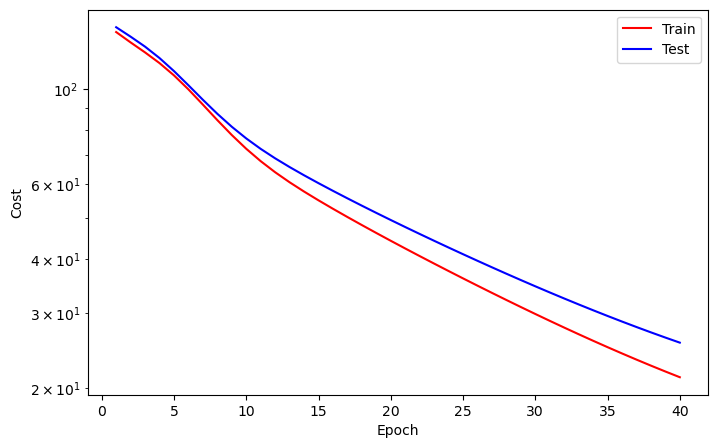

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 20.5785 | Test_cost  = 24.8649 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 19.9877 | Test_cost  = 24.2315 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 19.4303 | Test_cost  = 23.6320 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 18.9049 | Test_cost  = 23.0650 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 18.4100 | Test_cost  = 22.5288 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 17.9440 | Test_cost  = 22.0221 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 17.5056 | Test_cost  = 21.5435 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 17.0934 | Test_cost  = 21.0917 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 16.7061 | Test_cost  = 20.6653 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 16.3424 | Test_cost  = 20.2630 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 16.0012 | Test_cost  = 19.8838 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 15.6812 | Test_cost  = 19.5265 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 15.3814 | Test_cost  = 19.1899 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 15.1006 | Test_cost  = 18.8731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 14.8379 | Test_cost  = 18.5749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 14.5922 | Test_cost  = 18.2944 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 14.3627 | Test_cost  = 18.0307 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 14.1484 | Test_cost  = 17.7829 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 13.9484 | Test_cost  = 17.5502 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 13.7620 | Test_cost  = 17.3316 | 


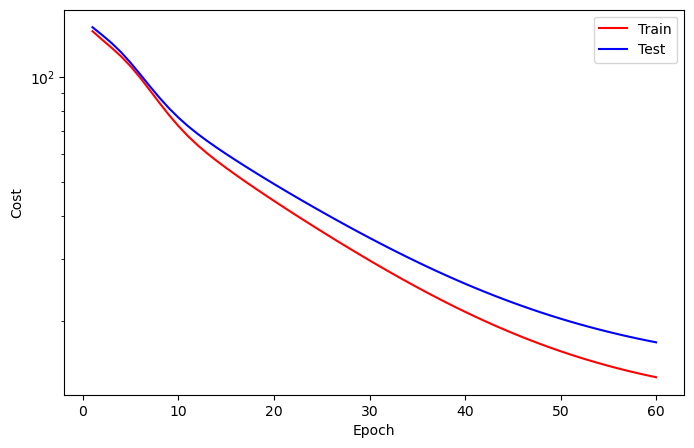

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 13.5884 | Test_cost  = 17.1265 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 13.4267 | Test_cost  = 16.9341 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 13.2763 | Test_cost  = 16.7537 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 13.1366 | Test_cost  = 16.5846 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 13.0068 | Test_cost  = 16.4261 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 12.8863 | Test_cost  = 16.2777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 12.7746 | Test_cost  = 16.1388 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 12.6711 | Test_cost  = 16.0087 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 12.5753 | Test_cost  = 15.8871 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 12.4866 | Test_cost  = 15.7733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 12.4047 | Test_cost  = 15.6670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 12.3290 | Test_cost  = 15.5675 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 12.2592 | Test_cost  = 15.4747 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 12.1948 | Test_cost  = 15.3879 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 12.1355 | Test_cost  = 15.3069 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 12.0808 | Test_cost  = 15.2312 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 12.0306 | Test_cost  = 15.1606 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.9844 | Test_cost  = 15.0947 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.9420 | Test_cost  = 15.0333 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.9030 | Test_cost  = 14.9759 | 


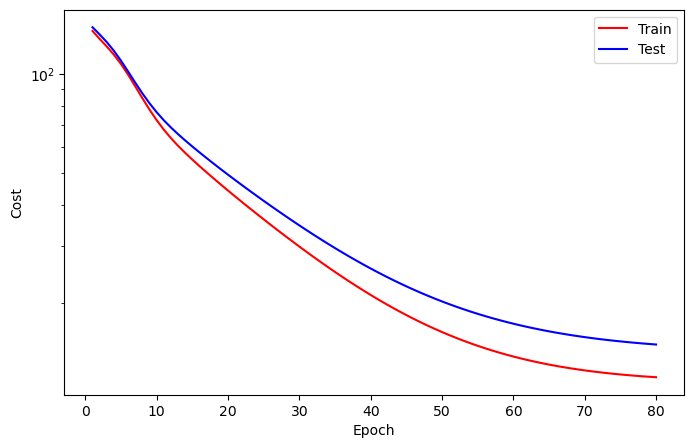

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 11.8673 | Test_cost  = 14.9224 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 11.8346 | Test_cost  = 14.8726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 11.8047 | Test_cost  = 14.8260 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 11.7773 | Test_cost  = 14.7827 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 11.7522 | Test_cost  = 14.7422 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 11.7293 | Test_cost  = 14.7046 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 11.7085 | Test_cost  = 14.6694 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 11.6894 | Test_cost  = 14.6367 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 11.6720 | Test_cost  = 14.6061 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 11.6562 | Test_cost  = 14.5777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 11.6418 | Test_cost  = 14.5512 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 11.6287 | Test_cost  = 14.5264 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 11.6168 | Test_cost  = 14.5034 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 11.6060 | Test_cost  = 14.4819 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 11.5962 | Test_cost  = 14.4619 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 11.5873 | Test_cost  = 14.4432 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 11.5792 | Test_cost  = 14.4258 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 11.5718 | Test_cost  = 14.4095 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 11.5652 | Test_cost  = 14.3944 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 11.5592 | Test_cost  = 14.3802 | 


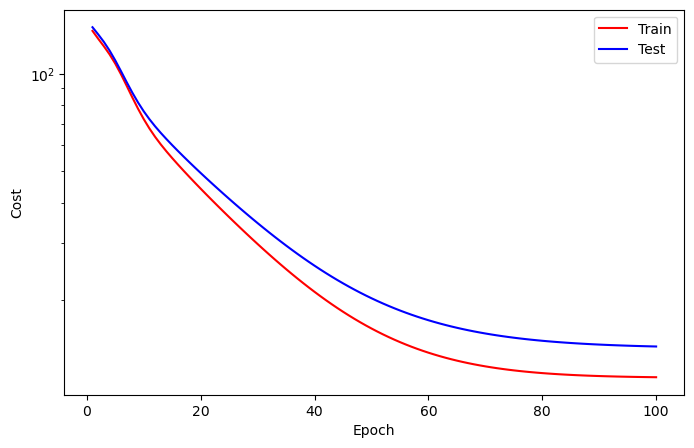

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.5538 | Test_cost  = 14.3670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.5488 | Test_cost  = 14.3547 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.5444 | Test_cost  = 14.3432 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.5403 | Test_cost  = 14.3325 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.5367 | Test_cost  = 14.3225 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.5334 | Test_cost  = 14.3132 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.5304 | Test_cost  = 14.3045 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.5278 | Test_cost  = 14.2963 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.5253 | Test_cost  = 14.2887 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.5231 | Test_cost  = 14.2816 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.5211 | Test_cost  = 14.2750 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 11.5193 | Test_cost  = 14.2688 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 11.5177 | Test_cost  = 14.2630 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 11.5162 | Test_cost  = 14.2576 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 11.5149 | Test_cost  = 14.2526 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 11.5137 | Test_cost  = 14.2478 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 11.5126 | Test_cost  = 14.2434 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 11.5116 | Test_cost  = 14.2393 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 11.5107 | Test_cost  = 14.2355 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 11.5099 | Test_cost  = 14.2319 | 


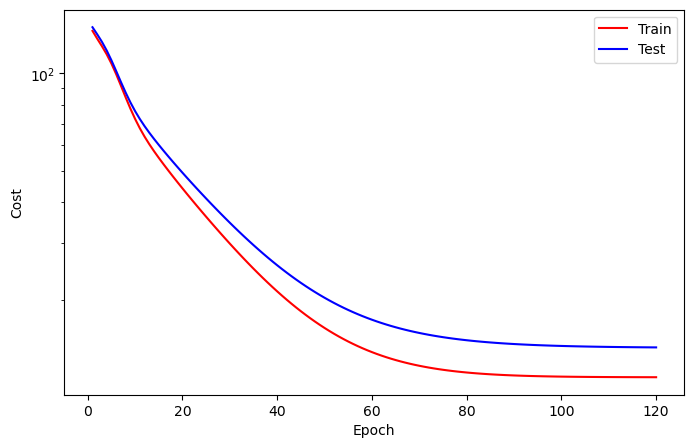

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 11.5091 | Test_cost  = 14.2285 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 11.5085 | Test_cost  = 14.2253 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 11.5078 | Test_cost  = 14.2224 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 11.5073 | Test_cost  = 14.2197 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 11.5067 | Test_cost  = 14.2171 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 11.5063 | Test_cost  = 14.2147 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 11.5058 | Test_cost  = 14.2125 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 11.5054 | Test_cost  = 14.2104 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 11.5050 | Test_cost  = 14.2084 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 11.5047 | Test_cost  = 14.2066 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 11.5043 | Test_cost  = 14.2049 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 11.5040 | Test_cost  = 14.2033 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 11.5037 | Test_cost  = 14.2018 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 11.5035 | Test_cost  = 14.2004 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 11.5032 | Test_cost  = 14.1991 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 11.5030 | Test_cost  = 14.1979 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 11.5027 | Test_cost  = 14.1967 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 11.5025 | Test_cost  = 14.1957 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 11.5023 | Test_cost  = 14.1947 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 11.5021 | Test_cost  = 14.1937 | 


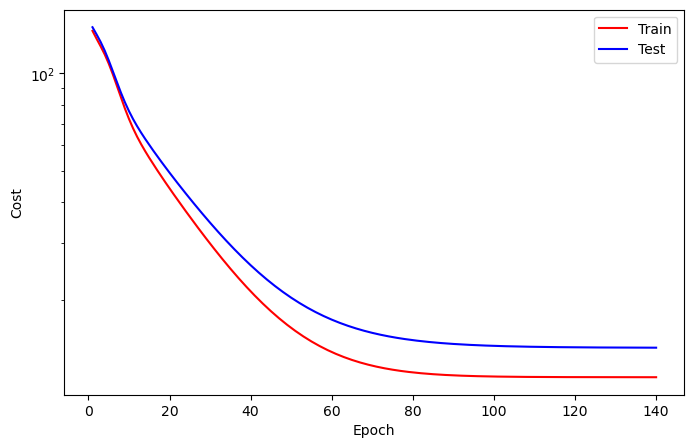

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 11.5019 | Test_cost  = 14.1929 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 11.5018 | Test_cost  = 14.1921 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 11.5016 | Test_cost  = 14.1913 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 11.5014 | Test_cost  = 14.1906 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 11.5012 | Test_cost  = 14.1899 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 11.5011 | Test_cost  = 14.1893 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 11.5009 | Test_cost  = 14.1887 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 11.5008 | Test_cost  = 14.1882 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 11.5006 | Test_cost  = 14.1877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 11.5005 | Test_cost  = 14.1872 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 11.5004 | Test_cost  = 14.1868 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 11.5002 | Test_cost  = 14.1863 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 11.5001 | Test_cost  = 14.1859 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 11.4999 | Test_cost  = 14.1856 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 11.4998 | Test_cost  = 14.1852 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 11.4997 | Test_cost  = 14.1849 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 11.4995 | Test_cost  = 14.1846 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 11.4994 | Test_cost  = 14.1843 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 11.4993 | Test_cost  = 14.1840 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 11.4992 | Test_cost  = 14.1838 | 


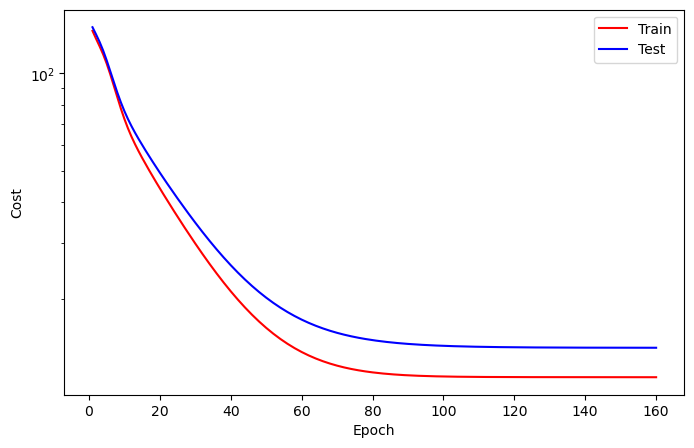

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 11.4990 | Test_cost  = 14.1835 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 11.4989 | Test_cost  = 14.1833 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 11.4988 | Test_cost  = 14.1831 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 11.4987 | Test_cost  = 14.1829 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 11.4985 | Test_cost  = 14.1827 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 11.4984 | Test_cost  = 14.1825 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 11.4983 | Test_cost  = 14.1823 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 11.4982 | Test_cost  = 14.1821 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 11.4980 | Test_cost  = 14.1820 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 11.4979 | Test_cost  = 14.1818 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 11.4978 | Test_cost  = 14.1816 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 11.4977 | Test_cost  = 14.1815 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 11.4976 | Test_cost  = 14.1814 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 11.4974 | Test_cost  = 14.1812 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 11.4973 | Test_cost  = 14.1811 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 11.4972 | Test_cost  = 14.1810 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 11.4971 | Test_cost  = 14.1808 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 11.4969 | Test_cost  = 14.1807 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 11.4968 | Test_cost  = 14.1806 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 11.4967 | Test_cost  = 14.1805 | 


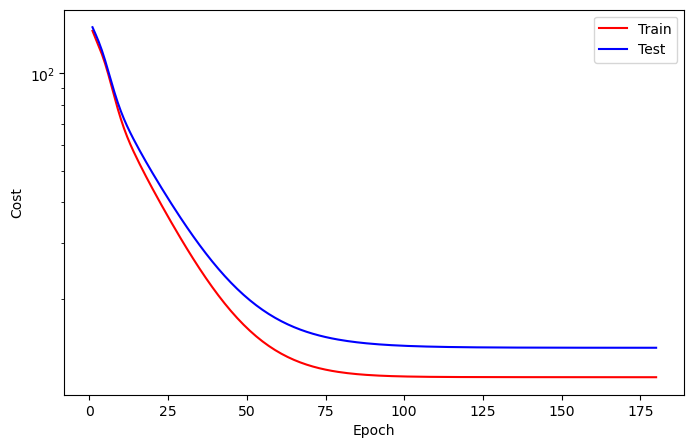

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 11.4966 | Test_cost  = 14.1804 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 11.4964 | Test_cost  = 14.1803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 11.4963 | Test_cost  = 14.1802 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 11.4962 | Test_cost  = 14.1801 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 11.4961 | Test_cost  = 14.1800 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 11.4959 | Test_cost  = 14.1799 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 11.4958 | Test_cost  = 14.1798 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 11.4957 | Test_cost  = 14.1797 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 11.4956 | Test_cost  = 14.1796 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 11.4954 | Test_cost  = 14.1795 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 11.4953 | Test_cost  = 14.1794 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 11.4952 | Test_cost  = 14.1793 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 11.4950 | Test_cost  = 14.1793 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 11.4949 | Test_cost  = 14.1792 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 11.4948 | Test_cost  = 14.1791 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 11.4947 | Test_cost  = 14.1790 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 11.4945 | Test_cost  = 14.1789 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 11.4944 | Test_cost  = 14.1789 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 11.4943 | Test_cost  = 14.1788 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 11.4941 | Test_cost  = 14.1787 | 


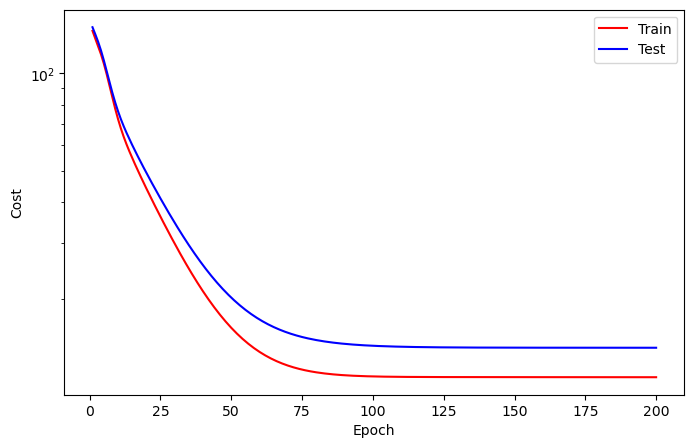

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 11.4940 | Test_cost  = 14.1786 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 11.4939 | Test_cost  = 14.1786 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 11.4937 | Test_cost  = 14.1785 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 11.4936 | Test_cost  = 14.1784 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 11.4935 | Test_cost  = 14.1783 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 11.4933 | Test_cost  = 14.1783 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 11.4932 | Test_cost  = 14.1782 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 11.4931 | Test_cost  = 14.1781 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 11.4929 | Test_cost  = 14.1781 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 11.4928 | Test_cost  = 14.1780 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 11.4927 | Test_cost  = 14.1779 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 11.4925 | Test_cost  = 14.1779 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 11.4924 | Test_cost  = 14.1778 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 11.4923 | Test_cost  = 14.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 11.4921 | Test_cost  = 14.1777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 11.4920 | Test_cost  = 14.1776 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 11.4918 | Test_cost  = 14.1775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 11.4917 | Test_cost  = 14.1775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 11.4916 | Test_cost  = 14.1774 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 11.4914 | Test_cost  = 14.1774 | 


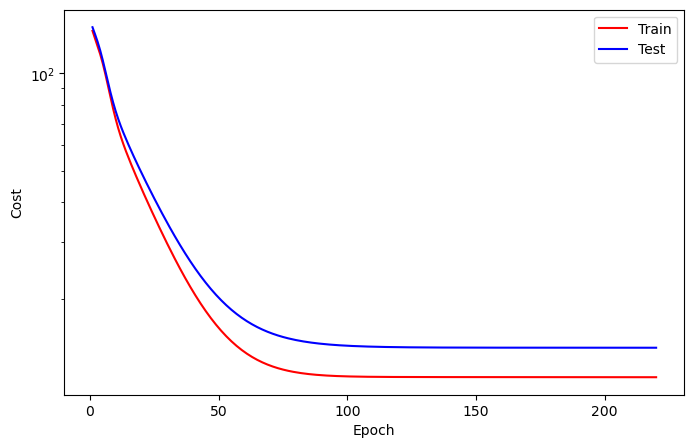

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 11.4913 | Test_cost  = 14.1773 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 11.4911 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 11.4910 | Test_cost  = 14.1772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 11.4909 | Test_cost  = 14.1771 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 11.4907 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 11.4906 | Test_cost  = 14.1770 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 11.4904 | Test_cost  = 14.1769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 11.4903 | Test_cost  = 14.1769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 11.4902 | Test_cost  = 14.1768 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 11.4900 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 11.4899 | Test_cost  = 14.1767 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 11.4897 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 11.4896 | Test_cost  = 14.1766 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 11.4894 | Test_cost  = 14.1765 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 11.4893 | Test_cost  = 14.1764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 11.4891 | Test_cost  = 14.1764 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 11.4890 | Test_cost  = 14.1763 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 11.4888 | Test_cost  = 14.1763 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 11.4887 | Test_cost  = 14.1762 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 11.4885 | Test_cost  = 14.1762 | 


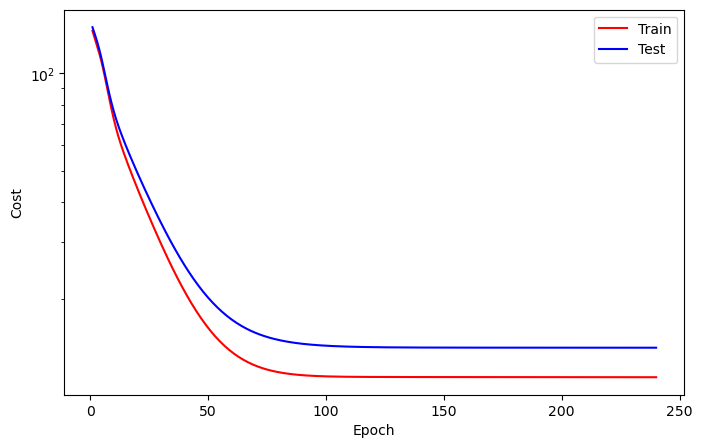

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 11.4884 | Test_cost  = 14.1761 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 11.4882 | Test_cost  = 14.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 11.4881 | Test_cost  = 14.1760 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 11.4879 | Test_cost  = 14.1759 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 11.4878 | Test_cost  = 14.1759 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 11.4876 | Test_cost  = 14.1758 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 11.4875 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 11.4873 | Test_cost  = 14.1757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 11.4871 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 11.4870 | Test_cost  = 14.1756 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 11.4868 | Test_cost  = 14.1755 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 11.4867 | Test_cost  = 14.1755 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 11.4865 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 11.4863 | Test_cost  = 14.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 11.4862 | Test_cost  = 14.1753 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 11.4860 | Test_cost  = 14.1752 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 11.4859 | Test_cost  = 14.1752 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 11.4857 | Test_cost  = 14.1751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 11.4855 | Test_cost  = 14.1751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 11.4854 | Test_cost  = 14.1750 | 


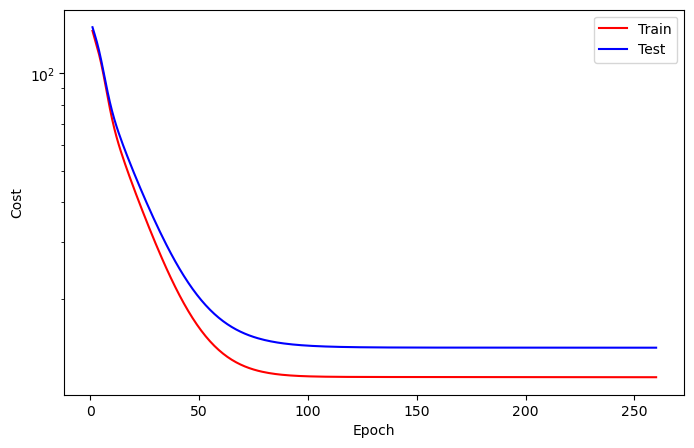

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 11.4852 | Test_cost  = 14.1750 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 11.4850 | Test_cost  = 14.1749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 11.4849 | Test_cost  = 14.1749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 11.4847 | Test_cost  = 14.1748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 11.4845 | Test_cost  = 14.1748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 11.4844 | Test_cost  = 14.1747 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 11.4842 | Test_cost  = 14.1747 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 11.4840 | Test_cost  = 14.1746 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 11.4839 | Test_cost  = 14.1746 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 11.4837 | Test_cost  = 14.1745 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 11.4835 | Test_cost  = 14.1745 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 11.4834 | Test_cost  = 14.1744 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 11.4832 | Test_cost  = 14.1744 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 11.4830 | Test_cost  = 14.1743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 11.4828 | Test_cost  = 14.1743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 11.4827 | Test_cost  = 14.1743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 11.4825 | Test_cost  = 14.1742 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 11.4823 | Test_cost  = 14.1742 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 11.4821 | Test_cost  = 14.1741 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 11.4820 | Test_cost  = 14.1741 | 


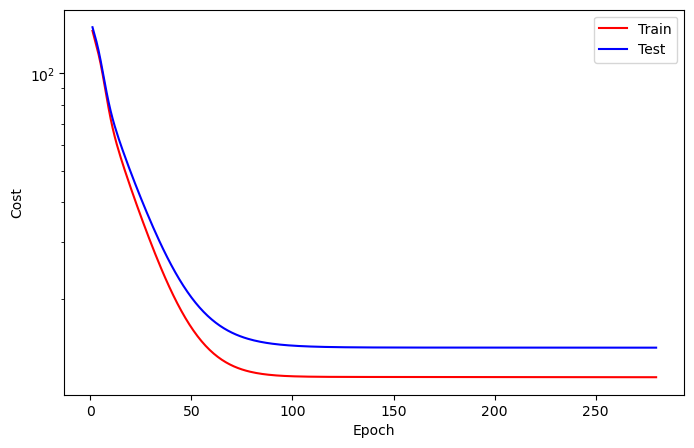

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 11.4818 | Test_cost  = 14.1740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 11.4816 | Test_cost  = 14.1740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 11.4814 | Test_cost  = 14.1740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 11.4813 | Test_cost  = 14.1739 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 11.4811 | Test_cost  = 14.1739 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 11.4809 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 11.4807 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 11.4805 | Test_cost  = 14.1738 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 11.4804 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 11.4802 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 11.4800 | Test_cost  = 14.1737 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 11.4798 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 11.4796 | Test_cost  = 14.1736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 11.4795 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 11.4793 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 11.4791 | Test_cost  = 14.1735 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 11.4789 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 11.4787 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 11.4785 | Test_cost  = 14.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 11.4783 | Test_cost  = 14.1733 | 


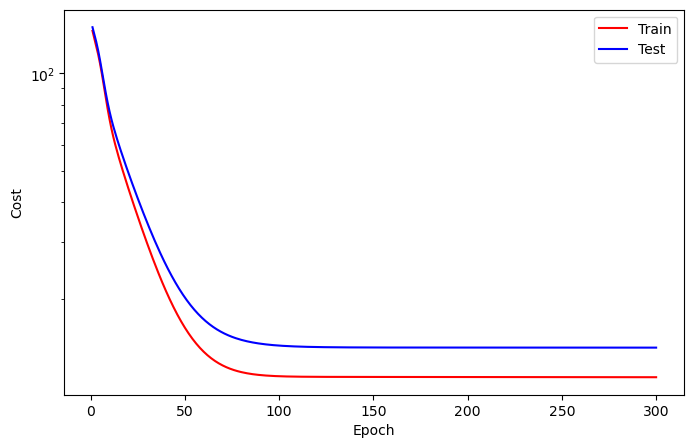

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 11.4782 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 11.4780 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 11.4778 | Test_cost  = 14.1733 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 11.4776 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 11.4774 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 11.4772 | Test_cost  = 14.1732 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 11.4770 | Test_cost  = 14.1731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 11.4768 | Test_cost  = 14.1731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 11.4767 | Test_cost  = 14.1731 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 11.4765 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 11.4763 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 11.4761 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 11.4759 | Test_cost  = 14.1730 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 11.4757 | Test_cost  = 14.1729 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 11.4755 | Test_cost  = 14.1729 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 11.4753 | Test_cost  = 14.1729 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 11.4751 | Test_cost  = 14.1728 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 11.4749 | Test_cost  = 14.1728 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 11.4747 | Test_cost  = 14.1728 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 11.4745 | Test_cost  = 14.1728 | 


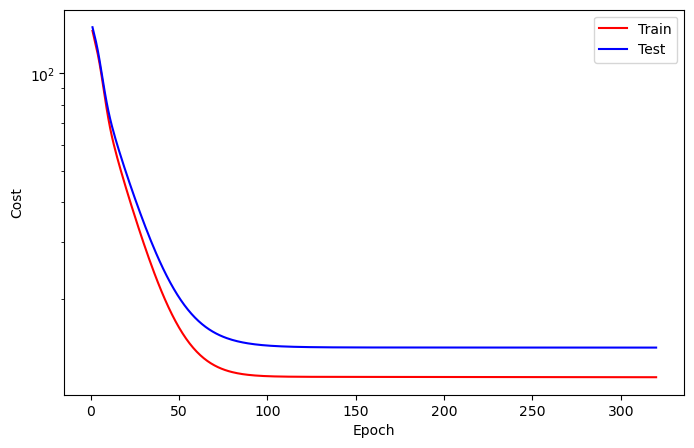

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 11.4743 | Test_cost  = 14.1727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 11.4741 | Test_cost  = 14.1727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 11.4739 | Test_cost  = 14.1727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 11.4737 | Test_cost  = 14.1727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 11.4736 | Test_cost  = 14.1726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 11.4734 | Test_cost  = 14.1726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 11.4732 | Test_cost  = 14.1726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 11.4730 | Test_cost  = 14.1726 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 11.4728 | Test_cost  = 14.1725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 11.4726 | Test_cost  = 14.1725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 11.4724 | Test_cost  = 14.1725 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 11.4722 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 11.4720 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 11.4718 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 11.4716 | Test_cost  = 14.1724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 11.4714 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 11.4711 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 11.4709 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 11.4707 | Test_cost  = 14.1723 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 11.4705 | Test_cost  = 14.1722 | 


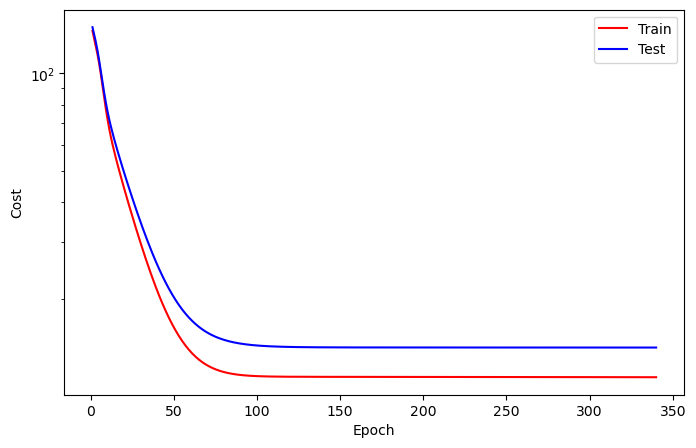

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 11.4703 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 11.4701 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 11.4699 | Test_cost  = 14.1722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 11.4697 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 11.4695 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 11.4693 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 11.4691 | Test_cost  = 14.1721 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 11.4689 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 11.4687 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 11.4685 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 11.4683 | Test_cost  = 14.1720 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 11.4680 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 11.4678 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 11.4676 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 11.4674 | Test_cost  = 14.1719 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 11.4672 | Test_cost  = 14.1718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 11.4670 | Test_cost  = 14.1718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 11.4668 | Test_cost  = 14.1718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 11.4666 | Test_cost  = 14.1718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 11.4663 | Test_cost  = 14.1717 | 


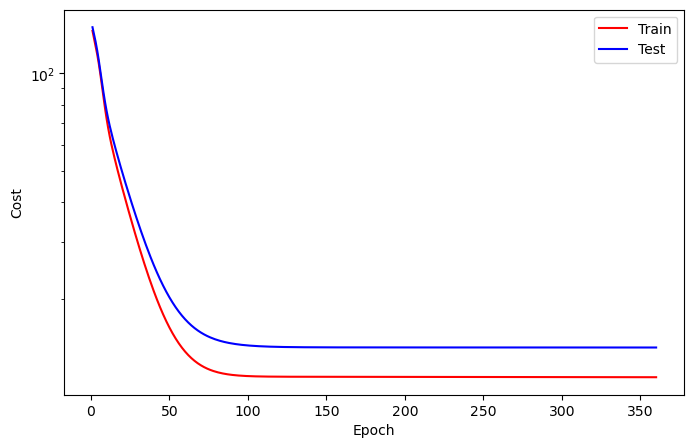

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 11.4661 | Test_cost  = 14.1717 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 11.4659 | Test_cost  = 14.1717 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 11.4657 | Test_cost  = 14.1717 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 11.4655 | Test_cost  = 14.1716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 11.4653 | Test_cost  = 14.1716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 11.4650 | Test_cost  = 14.1716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 11.4648 | Test_cost  = 14.1716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 11.4646 | Test_cost  = 14.1715 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 11.4644 | Test_cost  = 14.1715 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 11.4641 | Test_cost  = 14.1715 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 11.4639 | Test_cost  = 14.1715 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 11.4637 | Test_cost  = 14.1714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 11.4635 | Test_cost  = 14.1714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 11.4632 | Test_cost  = 14.1714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   375
Train_cost  = 11.4630 | Test_cost  = 14.1714 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   376
Train_cost  = 11.4628 | Test_cost  = 14.1713 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   377
Train_cost  = 11.4626 | Test_cost  = 14.1713 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   378
Train_cost  = 11.4623 | Test_cost  = 14.1713 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   379
Train_cost  = 11.4621 | Test_cost  = 14.1712 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   380
Train_cost  = 11.4619 | Test_cost  = 14.1712 | 


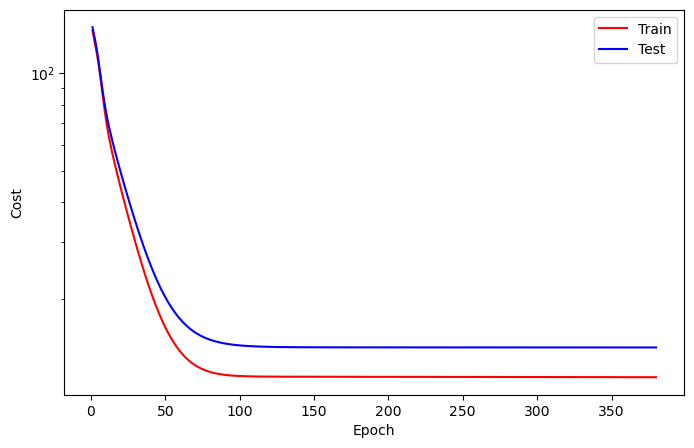

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   381
Train_cost  = 11.4616 | Test_cost  = 14.1712 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   382
Train_cost  = 11.4614 | Test_cost  = 14.1712 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 11.4611 | Test_cost  = 14.1711 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 11.4609 | Test_cost  = 14.1711 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 11.4607 | Test_cost  = 14.1711 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 11.4604 | Test_cost  = 14.1710 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 11.4602 | Test_cost  = 14.1710 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 11.4599 | Test_cost  = 14.1710 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 11.4597 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 11.4594 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 11.4592 | Test_cost  = 14.1709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 11.4589 | Test_cost  = 14.1708 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 11.4587 | Test_cost  = 14.1708 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 11.4584 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 11.4581 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 11.4578 | Test_cost  = 14.1707 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 11.4576 | Test_cost  = 14.1706 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 11.4573 | Test_cost  = 14.1706 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 11.4570 | Test_cost  = 14.1705 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 11.4567 | Test_cost  = 14.1704 | 


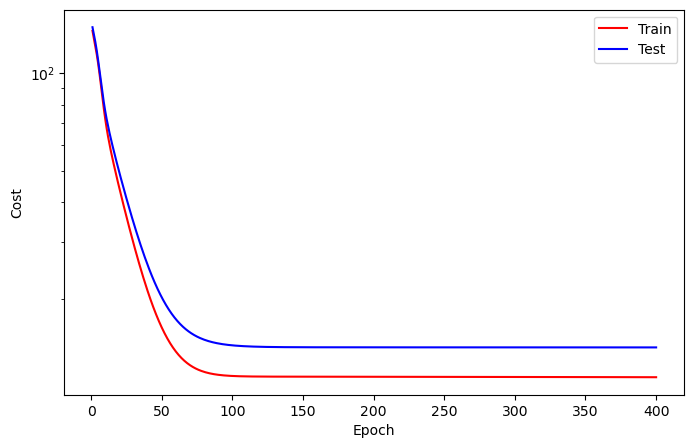

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 11.4564 | Test_cost  = 14.1704 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 11.4561 | Test_cost  = 14.1703 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 11.4558 | Test_cost  = 14.1702 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 11.4555 | Test_cost  = 14.1702 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 11.4552 | Test_cost  = 14.1701 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 11.4548 | Test_cost  = 14.1700 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 11.4545 | Test_cost  = 14.1699 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 11.4541 | Test_cost  = 14.1698 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 11.4537 | Test_cost  = 14.1697 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 11.4534 | Test_cost  = 14.1696 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 11.4530 | Test_cost  = 14.1694 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   412
Train_cost  = 11.4525 | Test_cost  = 14.1693 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   413
Train_cost  = 11.4521 | Test_cost  = 14.1691 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   414
Train_cost  = 11.4516 | Test_cost  = 14.1689 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   415
Train_cost  = 11.4511 | Test_cost  = 14.1687 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   416
Train_cost  = 11.4506 | Test_cost  = 14.1684 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   417
Train_cost  = 11.4500 | Test_cost  = 14.1682 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   418
Train_cost  = 11.4494 | Test_cost  = 14.1679 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   419
Train_cost  = 11.4488 | Test_cost  = 14.1675 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   420
Train_cost  = 11.4481 | Test_cost  = 14.1671 | 


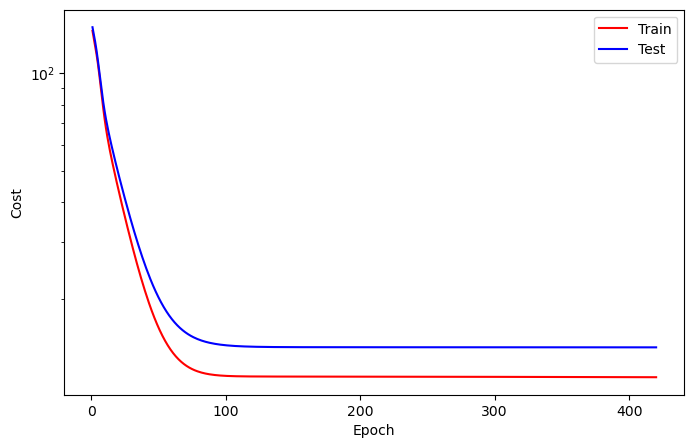

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 11.4473 | Test_cost  = 14.1667 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 11.4465 | Test_cost  = 14.1662 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   423
Train_cost  = 11.4456 | Test_cost  = 14.1656 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   424
Train_cost  = 11.4446 | Test_cost  = 14.1649 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 11.4435 | Test_cost  = 14.1641 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 11.4422 | Test_cost  = 14.1631 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 11.4408 | Test_cost  = 14.1620 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 11.4392 | Test_cost  = 14.1606 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 11.4373 | Test_cost  = 14.1589 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 11.4350 | Test_cost  = 14.1568 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 11.4324 | Test_cost  = 14.1543 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 11.4292 | Test_cost  = 14.1511 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 11.4253 | Test_cost  = 14.1470 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 11.4205 | Test_cost  = 14.1418 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 11.4144 | Test_cost  = 14.1349 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 11.4066 | Test_cost  = 14.1254 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 11.3961 | Test_cost  = 14.1120 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 11.3817 | Test_cost  = 14.0925 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 11.3612 | Test_cost  = 14.0644 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 11.3321 | Test_cost  = 14.0243 | 


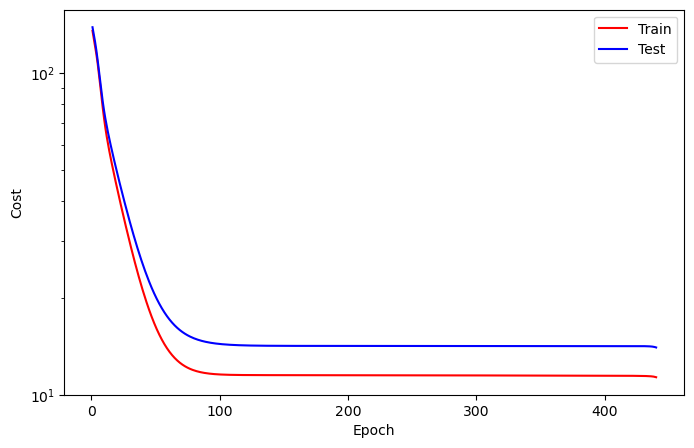

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 11.2914 | Test_cost  = 13.9687 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 11.2365 | Test_cost  = 13.8932 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 11.1645 | Test_cost  = 13.7813 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 11.0636 | Test_cost  = 13.5891 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 10.8985 | Test_cost  = 13.2607 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 10.6084 | Test_cost  = 12.5587 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   447
Train_cost  = 9.9325 | Test_cost  = 14.9358 | 
==> EarlyStop patience =  1 | Best test_cost: 12.5587


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   448
Train_cost  = 10.5850 | Test_cost  = 11.5118 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   449
Train_cost  = 9.2704 | Test_cost  = 11.7473 | 
==> EarlyStop patience =  1 | Best test_cost: 11.5118


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   450
Train_cost  = 9.4223 | Test_cost  = 11.0743 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   451
Train_cost  = 8.8696 | Test_cost  = 9.9566 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   452
Train_cost  = 8.1806 | Test_cost  = 9.5831 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   453
Train_cost  = 8.2259 | Test_cost  = 9.0652 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   454
Train_cost  = 7.5794 | Test_cost  = 9.0763 | 
==> EarlyStop patience =  1 | Best test_cost: 9.0652


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   455
Train_cost  = 7.4764 | Test_cost  = 8.9115 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   456
Train_cost  = 7.3598 | Test_cost  = 8.3976 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   457
Train_cost  = 7.0035 | Test_cost  = 8.1029 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   458
Train_cost  = 6.8526 | Test_cost  = 7.7498 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   459
Train_cost  = 6.5724 | Test_cost  = 7.5813 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   460
Train_cost  = 6.4313 | Test_cost  = 7.3806 | 


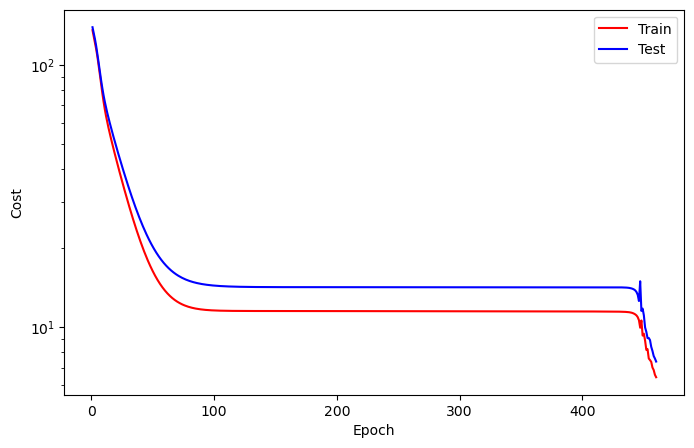

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   461
Train_cost  = 6.2930 | Test_cost  = 7.0652 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   462
Train_cost  = 6.1108 | Test_cost  = 6.8201 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   463
Train_cost  = 5.9927 | Test_cost  = 6.6046 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   464
Train_cost  = 5.8210 | Test_cost  = 6.4385 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   465
Train_cost  = 5.6729 | Test_cost  = 6.2585 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   466
Train_cost  = 5.5405 | Test_cost  = 6.0201 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   467
Train_cost  = 5.3873 | Test_cost  = 5.8264 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   468
Train_cost  = 5.2660 | Test_cost  = 5.6749 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   469
Train_cost  = 5.1362 | Test_cost  = 5.5574 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   470
Train_cost  = 5.0239 | Test_cost  = 5.4208 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   471
Train_cost  = 4.9061 | Test_cost  = 5.2658 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   472
Train_cost  = 4.7814 | Test_cost  = 5.1457 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   473
Train_cost  = 4.6727 | Test_cost  = 5.0516 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   474
Train_cost  = 4.5730 | Test_cost  = 4.9630 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   475
Train_cost  = 4.4874 | Test_cost  = 4.8467 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   476
Train_cost  = 4.3934 | Test_cost  = 4.7357 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   477
Train_cost  = 4.3105 | Test_cost  = 4.6421 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   478
Train_cost  = 4.2388 | Test_cost  = 4.5557 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   479
Train_cost  = 4.1782 | Test_cost  = 4.4517 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   480
Train_cost  = 4.1117 | Test_cost  = 4.3491 | 


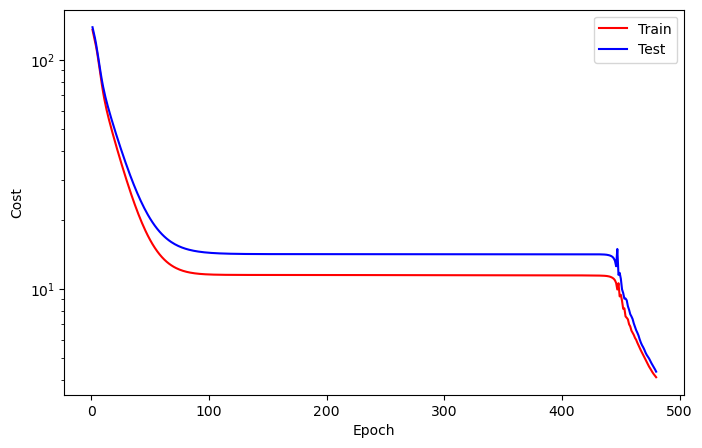

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   481
Train_cost  = 4.0484 | Test_cost  = 4.2619 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   482
Train_cost  = 3.9911 | Test_cost  = 4.1791 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   483
Train_cost  = 3.9394 | Test_cost  = 4.0854 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   484
Train_cost  = 3.8868 | Test_cost  = 4.0004 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   485
Train_cost  = 3.8402 | Test_cost  = 3.9302 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   486
Train_cost  = 3.8005 | Test_cost  = 3.8582 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   487
Train_cost  = 3.7632 | Test_cost  = 3.7854 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   488
Train_cost  = 3.7277 | Test_cost  = 3.7284 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   489
Train_cost  = 3.6964 | Test_cost  = 3.6818 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   490
Train_cost  = 3.6680 | Test_cost  = 3.6343 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   491
Train_cost  = 3.6397 | Test_cost  = 3.5946 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   492
Train_cost  = 3.6134 | Test_cost  = 3.5639 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   493
Train_cost  = 3.5893 | Test_cost  = 3.5311 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   494
Train_cost  = 3.5659 | Test_cost  = 3.4977 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   495
Train_cost  = 3.5434 | Test_cost  = 3.4701 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   496
Train_cost  = 3.5226 | Test_cost  = 3.4438 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   497
Train_cost  = 3.5029 | Test_cost  = 3.4187 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   498
Train_cost  = 3.4844 | Test_cost  = 3.3998 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   499
Train_cost  = 3.4671 | Test_cost  = 3.3831 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   500
Train_cost  = 3.4509 | Test_cost  = 3.3657 | 


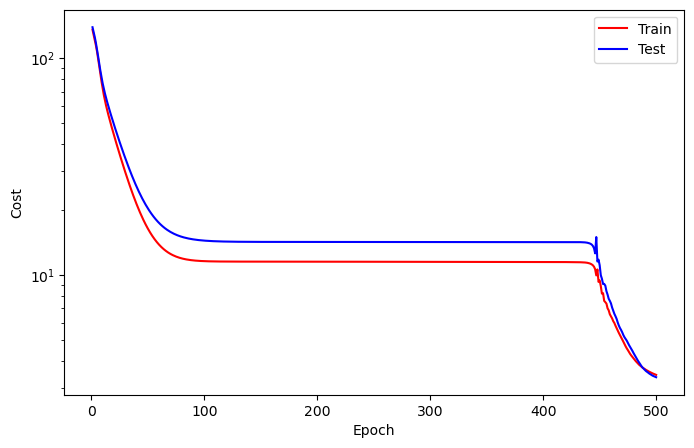

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   501
Train_cost  = 3.4359 | Test_cost  = 3.3507 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   502
Train_cost  = 3.4218 | Test_cost  = 3.3360 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   503
Train_cost  = 3.4085 | Test_cost  = 3.3209 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   504
Train_cost  = 3.3962 | Test_cost  = 3.3086 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   505
Train_cost  = 3.3844 | Test_cost  = 3.2974 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   506
Train_cost  = 3.3731 | Test_cost  = 3.2864 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   507
Train_cost  = 3.3626 | Test_cost  = 3.2769 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   508
Train_cost  = 3.3524 | Test_cost  = 3.2669 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   509
Train_cost  = 3.3429 | Test_cost  = 3.2568 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   510
Train_cost  = 3.3340 | Test_cost  = 3.2481 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   511
Train_cost  = 3.3256 | Test_cost  = 3.2398 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   512
Train_cost  = 3.3179 | Test_cost  = 3.2326 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   513
Train_cost  = 3.3109 | Test_cost  = 3.2262 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   514
Train_cost  = 3.3043 | Test_cost  = 3.2195 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   515
Train_cost  = 3.2986 | Test_cost  = 3.2134 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   516
Train_cost  = 3.2932 | Test_cost  = 3.2074 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   517
Train_cost  = 3.2883 | Test_cost  = 3.2019 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   518
Train_cost  = 3.2837 | Test_cost  = 3.1972 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   519
Train_cost  = 3.2793 | Test_cost  = 3.1927 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   520
Train_cost  = 3.2751 | Test_cost  = 3.1885 | 


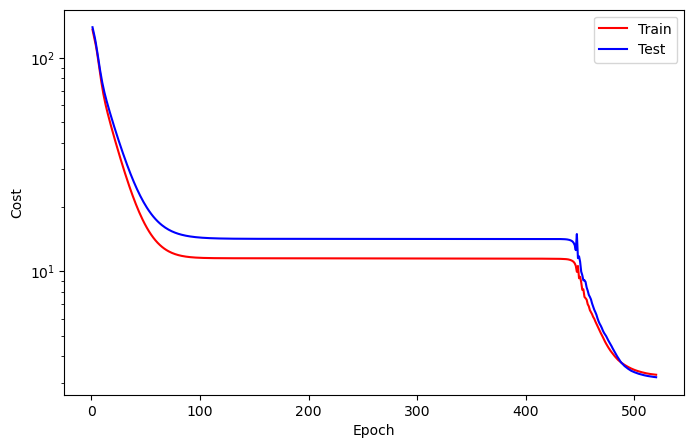

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   521
Train_cost  = 3.2709 | Test_cost  = 3.1841 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   522
Train_cost  = 3.2667 | Test_cost  = 3.1795 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   523
Train_cost  = 3.2624 | Test_cost  = 3.1751 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   524
Train_cost  = 3.2578 | Test_cost  = 3.1705 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   525
Train_cost  = 3.2531 | Test_cost  = 3.1661 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   526
Train_cost  = 3.2482 | Test_cost  = 3.1614 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   527
Train_cost  = 3.2431 | Test_cost  = 3.1567 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   528
Train_cost  = 3.2379 | Test_cost  = 3.1520 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   529
Train_cost  = 3.2324 | Test_cost  = 3.1475 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   530
Train_cost  = 3.2268 | Test_cost  = 3.1433 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   531
Train_cost  = 3.2211 | Test_cost  = 3.1393 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   532
Train_cost  = 3.2153 | Test_cost  = 3.1354 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   533
Train_cost  = 3.2094 | Test_cost  = 3.1317 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   534
Train_cost  = 3.2034 | Test_cost  = 3.1282 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   535
Train_cost  = 3.1975 | Test_cost  = 3.1250 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   536
Train_cost  = 3.1914 | Test_cost  = 3.1219 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   537
Train_cost  = 3.1854 | Test_cost  = 3.1190 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   538
Train_cost  = 3.1793 | Test_cost  = 3.1162 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   539
Train_cost  = 3.1732 | Test_cost  = 3.1136 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   540
Train_cost  = 3.1670 | Test_cost  = 3.1112 | 


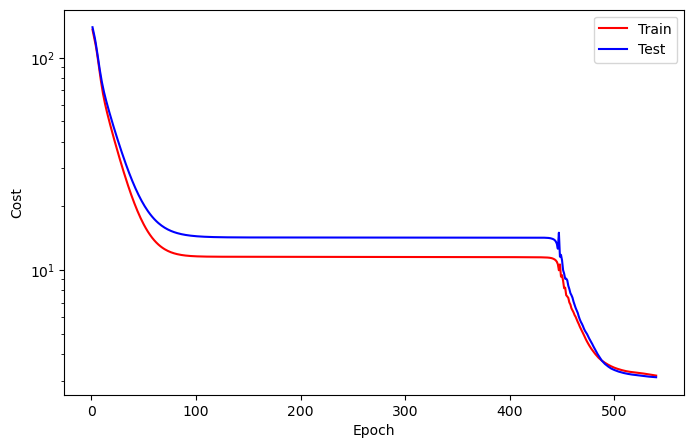

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   541
Train_cost  = 3.1609 | Test_cost  = 3.1090 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   542
Train_cost  = 3.1547 | Test_cost  = 3.1069 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   543
Train_cost  = 3.1486 | Test_cost  = 3.1049 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   544
Train_cost  = 3.1425 | Test_cost  = 3.1029 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   545
Train_cost  = 3.1365 | Test_cost  = 3.1010 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   546
Train_cost  = 3.1305 | Test_cost  = 3.0990 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   547
Train_cost  = 3.1247 | Test_cost  = 3.0969 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   548
Train_cost  = 3.1189 | Test_cost  = 3.0948 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   549
Train_cost  = 3.1132 | Test_cost  = 3.0925 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   550
Train_cost  = 3.1075 | Test_cost  = 3.0901 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   551
Train_cost  = 3.1018 | Test_cost  = 3.0877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   552
Train_cost  = 3.0961 | Test_cost  = 3.0852 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   553
Train_cost  = 3.0904 | Test_cost  = 3.0827 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   554
Train_cost  = 3.0846 | Test_cost  = 3.0803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   555
Train_cost  = 3.0788 | Test_cost  = 3.0780 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   556
Train_cost  = 3.0729 | Test_cost  = 3.0757 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   557
Train_cost  = 3.0669 | Test_cost  = 3.0736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   558
Train_cost  = 3.0608 | Test_cost  = 3.0716 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   559
Train_cost  = 3.0547 | Test_cost  = 3.0696 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   560
Train_cost  = 3.0486 | Test_cost  = 3.0679 | 


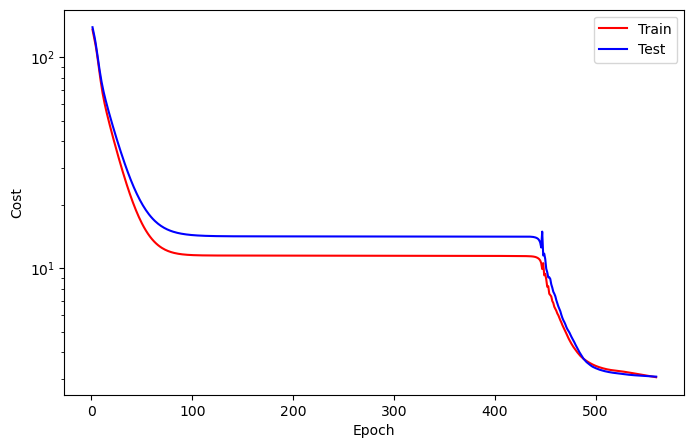

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   561
Train_cost  = 3.0424 | Test_cost  = 3.0661 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   562
Train_cost  = 3.0361 | Test_cost  = 3.0645 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   563
Train_cost  = 3.0298 | Test_cost  = 3.0630 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   564
Train_cost  = 3.0235 | Test_cost  = 3.0619 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   565
Train_cost  = 3.0171 | Test_cost  = 3.0608 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   566
Train_cost  = 3.0108 | Test_cost  = 3.0603 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   567
Train_cost  = 3.0044 | Test_cost  = 3.0598 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   568
Train_cost  = 2.9980 | Test_cost  = 3.0601 | 
==> EarlyStop patience =  1 | Best test_cost: 3.0598


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   569
Train_cost  = 2.9915 | Test_cost  = 3.0604 | 
==> EarlyStop patience =  2 | Best test_cost: 3.0598


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   570
Train_cost  = 2.9849 | Test_cost  = 3.0612 | 
==> EarlyStop patience =  3 | Best test_cost: 3.0598


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   571
Train_cost  = 2.9780 | Test_cost  = 3.0619 | 
==> EarlyStop patience =  4 | Best test_cost: 3.0598


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   572
Train_cost  = 2.9707 | Test_cost  = 3.0624 | 
==> EarlyStop patience =  5 | Best test_cost: 3.0598
==> Execute Early Stopping at epoch: 572 | Best test_cost: 3.0598
==> Best model is saved at model/gru


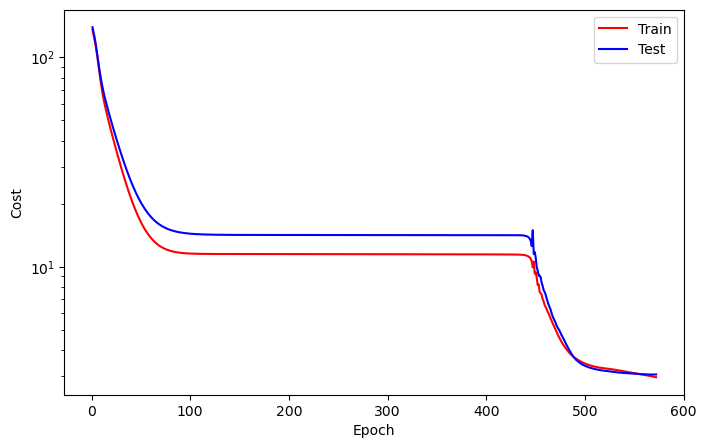

In [31]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Forecast

In [32]:
from luwiji.rnn import illustration

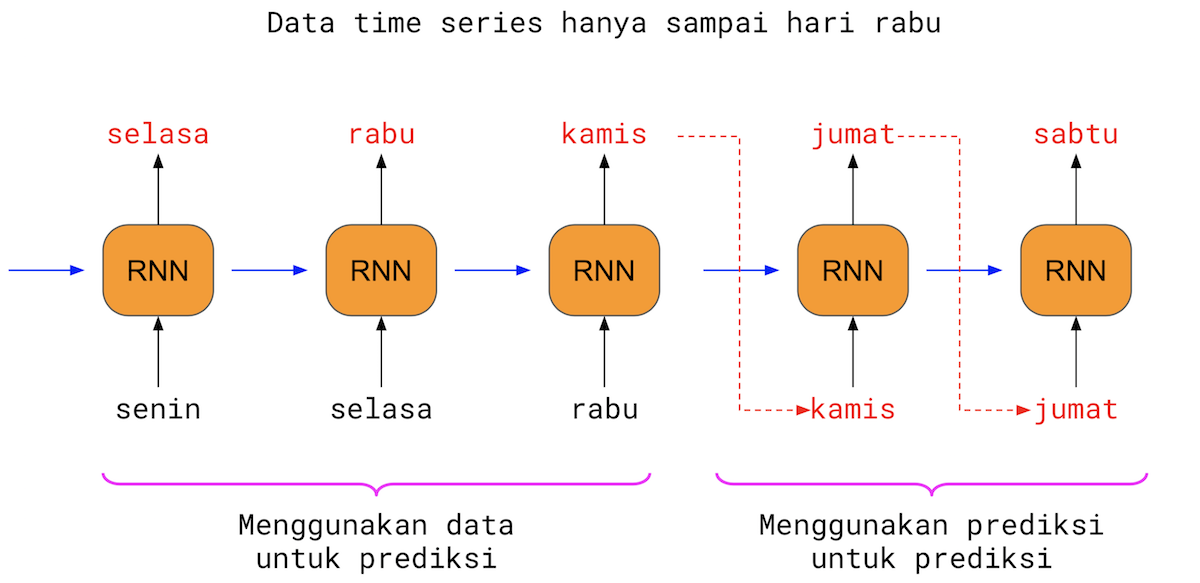

In [33]:
illustration.forecast

senin untuk prediksi hari selasa sebagai training,

selasa untuk prediksi hari rabu sebagai training,

rabu untuk prediksi hari kamis sebagai training,

kamis hasil prediksi digunakan untuk prediksi jumat dan seterusnya

yang kiri untuk training, yang kanan di pakai untuk prediksi masa depan

In [34]:
from utils import data4pred, pred4pred

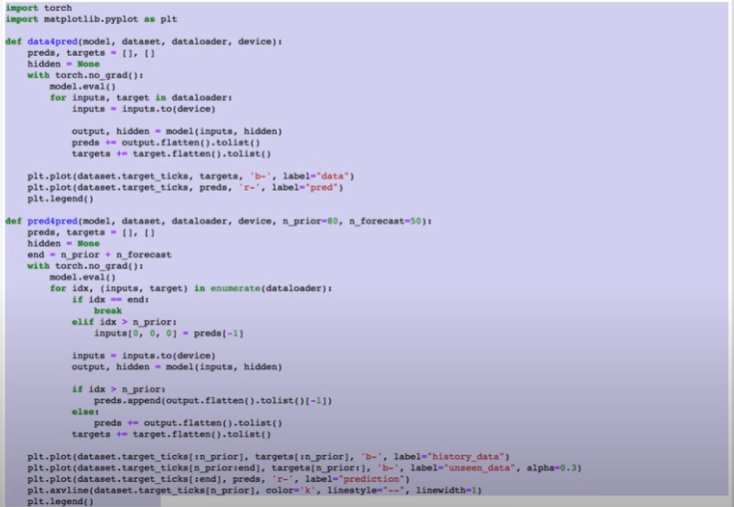

In [35]:
import torch
import matplotlib.pyplot as plt

def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()
    
    plt.plot(dataset.target_ticks, targets, 'b-', label='data')
    plt.plot(dataset.target_ticks, preds, 'r-', label='pred')
    plt.legend()
    
def pred4pred(model, dataset, dataloader, device, n_prior=80, n_forecast=50):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
            
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()
            
    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label='unseen_data', alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, "r-", label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle='--', linewidth=1)
    plt.legend()

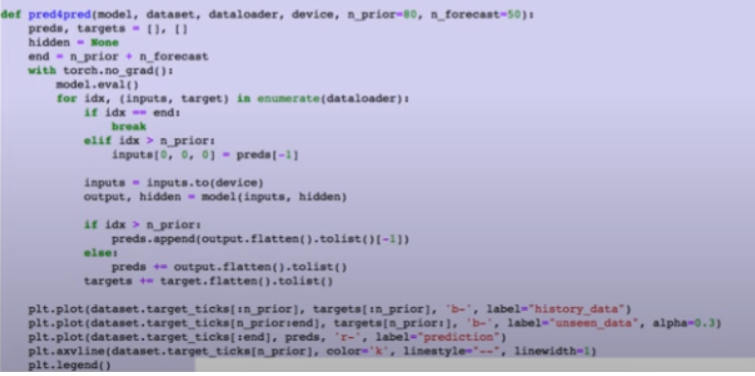

In [36]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



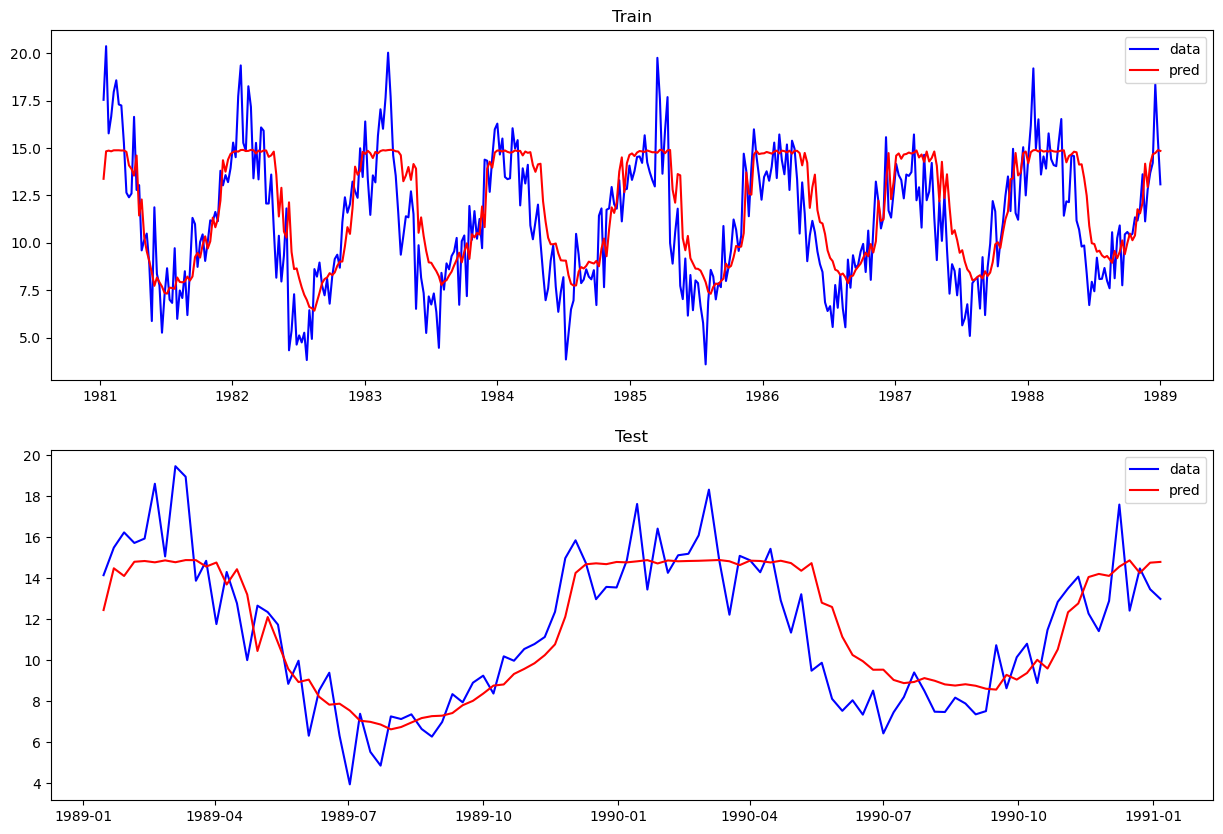

In [37]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test");

Text(0.5, 1.0, 'test')

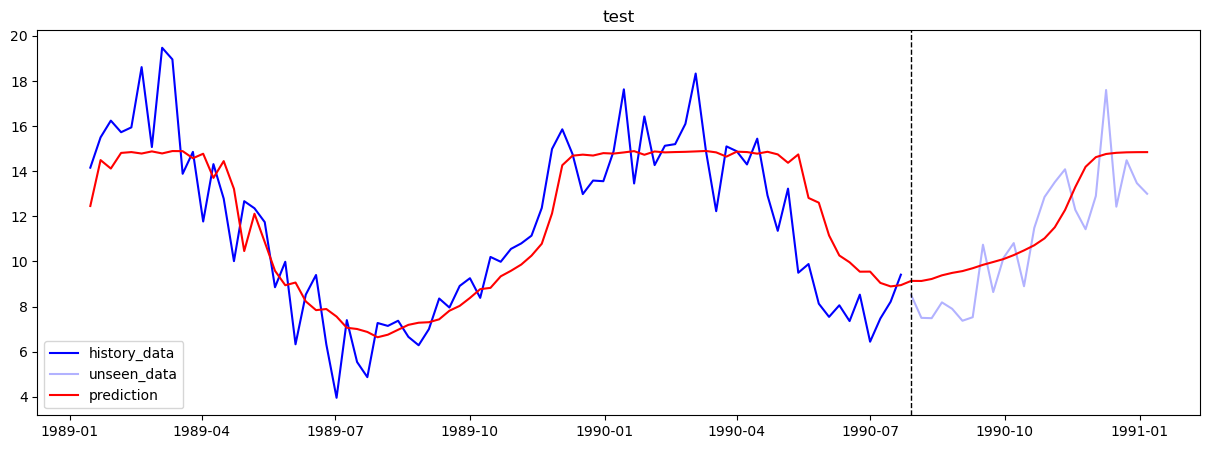

In [38]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")

note:

di time series forecasting by default itu overfit, kita harus expect prediksi kita salah. ketika data baru prediksi kita meleset

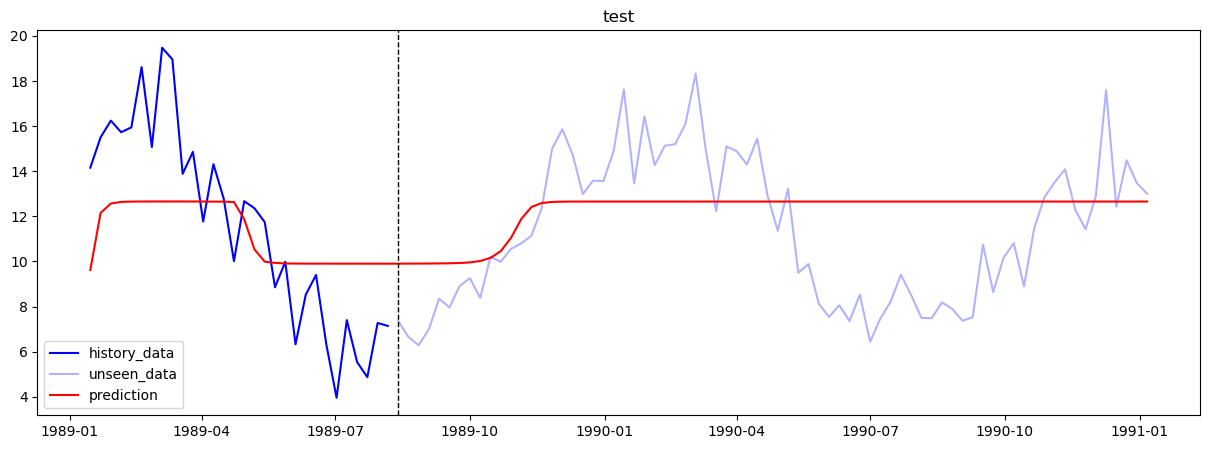

In [35]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device, n_prior=30, n_forecast=110)
plt.title("test");